In [1]:
import os
import re
import random
import pandas as pd
import matplotlib.pyplot as plt

from mecab import MeCab
from konlpy.tag import Okt
from collections import Counter

In [2]:
data_path = "../dataset"

train_df = pd.read_csv(f"{data_path}/train.csv")
valid_df = pd.read_csv(f"{data_path}/dev.csv")
test_df = pd.read_csv(f"{data_path}/test.csv")

In [3]:
print("Train DataFrame")
print(train_df.shape)
print(train_df.columns)

print("\nValid DataFrame")
print(valid_df.shape)
print(valid_df.columns)

print("\nTest DataFrame")
print(test_df.shape)
print(test_df.columns)

Train DataFrame
(12457, 4)
Index(['fname', 'dialogue', 'summary', 'topic'], dtype='object')

Valid DataFrame
(499, 4)
Index(['fname', 'dialogue', 'summary', 'topic'], dtype='object')

Test DataFrame
(499, 2)
Index(['fname', 'dialogue'], dtype='object')


# 1.Sample Row 확인

In [4]:
idx = random.randint(0, train_df.shape[0]-1)
sample = train_df.iloc[idx]
print(sample, "\n")

print(f"전체 대화 :\n{sample['dialogue']} \n")
print(f"요약 내용 :\n{sample['summary']}, \n")
print(f"대화 주제 :\n {sample['topic']}, \n")

fname                                              train_4927
dialogue    #Person1#: 차가 고장나면 어떻게 해야 하는지 알려주실 수 있나요?\n#Pe...
summary               #Person1#이 스미스 부인에게 차가 고장나면 전화하라고 말합니다.
topic                                                  자동차 수리
Name: 4927, dtype: object 

전체 대화 :
#Person1#: 차가 고장나면 어떻게 해야 하는지 알려주실 수 있나요?
#Person2#: 스미스 부인, 별문제 없으리라 확신합니다만, 만약 무슨 일이 생기면 이 번호로 전화하세요. 그들이 도움받을 수 있도록 알아봐 줄 것입니다. 

요약 내용 :
#Person1#이 스미스 부인에게 차가 고장나면 전화하라고 말합니다., 

대화 주제 :
 자동차 수리, 



# 2.데이터 길이

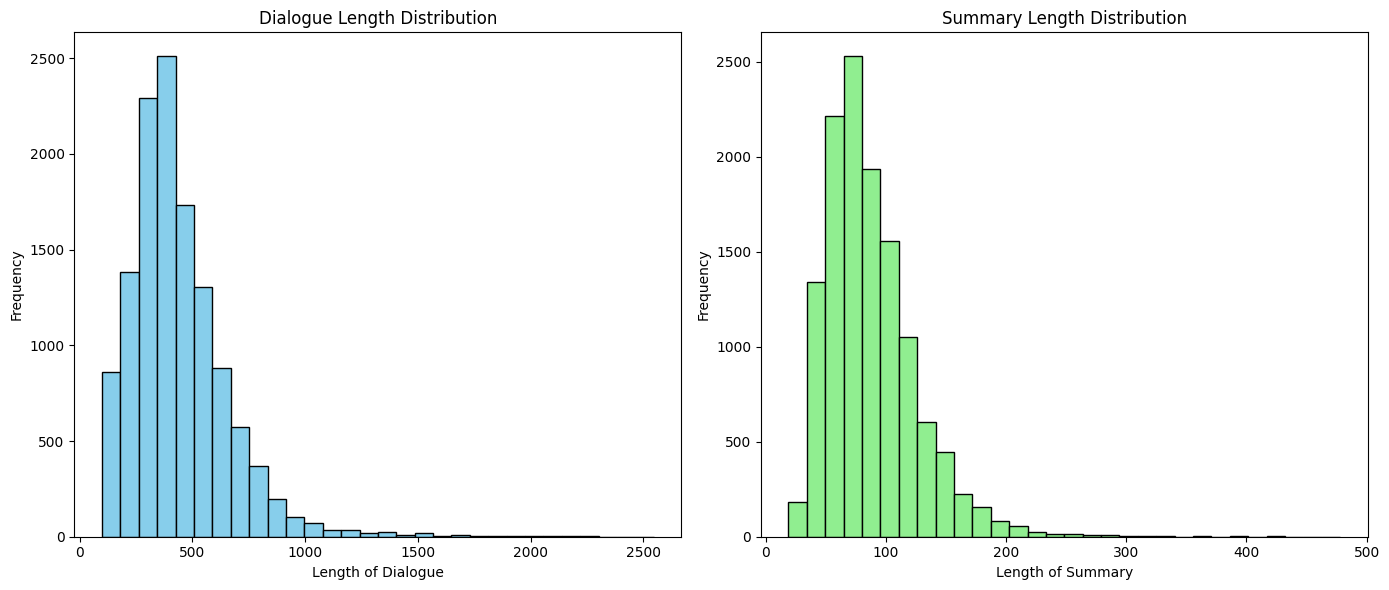

In [5]:
# dialogue와 summary의 길이를 계산
train_df['dialogue_length'] = train_df['dialogue'].apply(len)
train_df['summary_length'] = train_df['summary'].apply(len)

# 시각화
plt.figure(figsize=(14, 6))

# Dialogue 길이 시각화
plt.subplot(1, 2, 1)
plt.hist(train_df['dialogue_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Dialogue Length Distribution')
plt.xlabel('Length of Dialogue')
plt.ylabel('Frequency')

# Summary 길이 시각화
plt.subplot(1, 2, 2)
plt.hist(train_df['summary_length'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Summary Length Distribution')
plt.xlabel('Length of Summary')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
# min, max, mode 길이를 계산하는 함수 정의
def get_length_stats(column):
    min_length = column.min()
    max_length = column.max()
    mode_length = column.mode()[0]
    return min_length, max_length, mode_length

# dialogue와 summary의 길이에 대한 통계 계산
dialogue_min, dialogue_max, dialogue_mode = get_length_stats(train_df['dialogue_length'])
summary_min, summary_max, summary_mode = get_length_stats(train_df['summary_length'])

dialogue_stats = {
    'Dialogue': {
        'Min Length': dialogue_min,
        'Max Length': dialogue_max,
        'Mode Length': dialogue_mode
    },
    'Summary': {
        'Min Length': summary_min,
        'Max Length': summary_max,
        'Mode Length': summary_mode
    }
}

print(dialogue_stats)

{'Dialogue': {'Min Length': 99, 'Max Length': 2546, 'Mode Length': 350}, 'Summary': {'Min Length': 19, 'Max Length': 478, 'Mode Length': 63}}


# 3.특수 문자열

In [7]:
train_df['is_train'] = 1
valid_df['is_train'] = 0
total_df = pd.concat([train_df, valid_df], ignore_index=True)

In [8]:
# 특수 문자열 패턴 찾기 함수
def find_special_strings(text):
    return re.findall(r'#\w+#', text)

total_df['dialogue_special_strings'] = total_df['dialogue'].apply(find_special_strings)
total_df['summary_special_strings'] = total_df['summary'].apply(find_special_strings)

# total_df[['dialogue_special_strings', 'summary_special_strings']].head()
unique_dialogue_strings = set([item for sublist in total_df['dialogue_special_strings'] for item in sublist])
unique_summary_strings = set([item for sublist in total_df['summary_special_strings'] for item in sublist])

print(unique_dialogue_strings)
print(unique_summary_strings)

{'#DateOfBirth#', '#Person4#', '#SSN#', '#Person#', '#CarNumber#', '#Email#', '#Person7#', '#Person2#', '#CardNumber#', '#Person1#', '#Address#', '#Person3#', '#PhoneNumber#', '#PassportNumber#', '#Person5#', '#Person6#'}
{'#Person4#', '#Person7#', '#Person2#', '#Person1#', '#Person3#', '#사람1#', '#Person6#'}


In [9]:
# '#Person#'을 포함하고 있는 행을 찾는 함수
def contains_person_string(strings):
    return any('#Person#' in s for s in strings)

df_contains_person = total_df[total_df['dialogue_special_strings'].apply(contains_person_string) | total_df['summary_special_strings'].apply(contains_person_string)]

for idx, dialogue in enumerate(df_contains_person['dialogue']):
    print(f"Row {idx}: {dialogue}\n")

Row 0: #Person1#: 지미의 성적표가 오늘 왔어.
#Person#: 한번 봐볼까. 이게 뭐야? 성적이 어디에 있지?
#Person1#: 샘, 지미는 3학년이야! 학교에서 배우는 각 과목 아래에 보면, 지미가 1에서 3까지의 점수를 받은 걸 볼 수 있어. 1은 지미의 성취도나 작업이 우수하다는 뜻이야. 예를 들어 여기 과학에서는 지미가 2를 받았는데, 이건 잘했다는 뜻이야.
#Person2#: 여기 체육은?
#Person1#: 체육에서는 3을 받았으니까, 이건 못했다는 뜻이네. 우리가 지미랑 같이 연습해야겠다.
#Person2#: 너무 헷갈려! 우리 때는 잘하면 A나 B를 받았고, 시험을 못 보면 F를 받았잖아!



In [10]:
# 대체할 문자열 매핑 딕셔너리
replace_dict = {
    '#Person#': '#Person2#',
    '#사람1#': '#Person1#'
}

def replace_strings(text, replace_dict):
    for old_str, new_str in replace_dict.items():
        text = text.replace(old_str, new_str)
    return text

total_df['dialogue'] = total_df['dialogue'].apply(replace_strings, replace_dict=replace_dict)
total_df['summary'] = total_df['summary'].apply(replace_strings, replace_dict=replace_dict)
total_df[['dialogue', 'summary']].head()

dialogue  \
0  #Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...   
1  #Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...   
2  #Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...   
3  #Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...   
4  #Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...   

                                             summary  
0  스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...  
1  파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...  
2  #Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...  
3  #Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...  
4  말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...

In [11]:
## 결과 확인
total_df['dialogue_special_strings'] = total_df['dialogue'].apply(find_special_strings)
total_df['summary_special_strings'] = total_df['summary'].apply(find_special_strings)

# total_df[['dialogue_special_strings', 'summary_special_strings']].head()
unique_dialogue_strings = set([item for sublist in total_df['dialogue_special_strings'] for item in sublist])
unique_summary_strings = set([item for sublist in total_df['summary_special_strings'] for item in sublist])

print(unique_dialogue_strings)
print(unique_summary_strings)

{'#DateOfBirth#', '#Person4#', '#SSN#', '#CarNumber#', '#Email#', '#Person7#', '#Person2#', '#CardNumber#', '#Person1#', '#Address#', '#Person3#', '#PhoneNumber#', '#PassportNumber#', '#Person5#', '#Person6#'}
{'#Person4#', '#Person7#', '#Person2#', '#Person1#', '#Person3#', '#Person6#'}


# 4.형태소 분석

## Sample

In [12]:
## 분석하기 전에 [#문자열#:]을 제거한다.
def remove_speaker_tags(text):
    return re.sub(r'#\w+#:', '', text)

In [13]:
okt = Okt()

cleaned_dialogue_sample = remove_speaker_tags(train_df['dialogue'].iloc[0])
morphs = okt.morphs(cleaned_dialogue_sample)
print(morphs)

['안녕하세요', ',', '스미스', '씨', '.', '저', '는', '호킨스', '의사', '입니다', '.', '오늘', '왜', '오셨나요', '?', '\n ', '건강검진', '을', '받는', '것', '이', '좋을', '것', '같아서요', '.', '\n ', '그렇군요', ',', '당신', '은', '5년', '동안', '건강검진', '을', '받지', '않았습니다', '.', '매년', '받아야', '합니다', '.', '\n ', '알', '고', '있습니다', '.', '하지만', '아무', '문제', '가', '없다면', '왜', '의사', '를', '만나러', '가야', '하나요', '?', '\n ', '심각한', '질병', '을', '피하', '는', '가장', '좋은', '방법', '은', '이를', '조기', '에', '발견', '하는', '것', '입니다', '.', '그러니', '당신', '의', '건강', '을', '위해', '최소한', '매년', '한', '번은', '오세요', '.', '\n ', '알겠습니다', '.', '\n ', '여기', '보세요', '.', '당신', '의', '눈', '과', '귀', '는', '괜찮아', '보입니다', '.', '깊게', '숨', '을', '들이', '쉬세요', '.', '스미스', '씨', ',', '담배', '피우시나요', '?', '\n ', '네', '.', '\n ', '당신', '도', '알다시피', ',', '담배', '는', '폐암', '과', '심장병', '의', '주요', '원인', '입니다', '.', '정말로', '끊으셔야', '합니다', '.', '수백', '번', '시도', '했지만', ',', '습관', '을', '버리는', '것', '이', '어렵습니다', '.', '\n ', '우리', '는', '도움', '이', '될', '수', '있는', '수업', '과', '약물', '들', '을', '제공', '하고', '있습니다', '.', '

In [14]:
## 개행 문자 제거.
def remove_newlines(text):
    # 개행 문자를 문장부호 뒤에 공백과 함께 추가
    text = re.sub(r'([.?!])\n', r'\1 ', text)

    # 개행 문자가 남아있는 경우 제거
    return text.replace('\n', ' ')

In [15]:
cleaned_dialogue_sample = remove_speaker_tags(train_df['dialogue'].iloc[0])
cleaned_dialogue_sample = remove_newlines(cleaned_dialogue_sample)

mecab = MeCab()
morphs = mecab.morphs(cleaned_dialogue_sample)
print(morphs)

['안녕', '하', '세요', ',', '스미스', '씨', '.', '저', '는', '호킨스', '의사', '입니다', '.', '오늘', '왜', '오', '셨', '나요', '?', '건강', '검진', '을', '받', '는', '것', '이', '좋', '을', '것', '같', '아서요', '.', '그렇', '군요', ',', '당신', '은', '5', '년', '동안', '건강', '검진', '을', '받', '지', '않', '았', '습니다', '.', '매년', '받', '아야', '합니다', '.', '알', '고', '있', '습니다', '.', '하지만', '아무', '문제', '가', '없', '다면', '왜', '의사', '를', '만나', '러', '가', '야', '하', '나요', '?', '심각', '한', '질병', '을', '피하', '는', '가장', '좋', '은', '방법', '은', '이', '를', '조기', '에', '발견', '하', '는', '것', '입니다', '.', '그러', '니', '당신', '의', '건강', '을', '위해', '최소한', '매년', '한', '번', '은', '오', '세요', '.', '알', '겠', '습니다', '.', '여기', '보', '세요', '.', '당신', '의', '눈', '과', '귀', '는', '괜찮', '아', '보', '입니다', '.', '깊', '게', '숨', '을', '들이쉬', '세요', '.', '스미스', '씨', ',', '담배', '피우', '시', '나요', '?', '네', '.', '당신', '도', '알', '다시피', ',', '담배', '는', '폐암', '과', '심장', '병', '의', '주요', '원인', '입니다', '.', '정말로', '끊', '으셔야', '합니다', '.', '수백', '번', '시도', '했', '지만', ',', '습관', '을', '버리', '는', '것', '이', '어렵', '습

## Total

In [16]:
mecab = MeCab()

# Dialogue와 Summary 형태소 분석
total_df['cleaned_dialogue'] = total_df['dialogue'].apply(lambda x: remove_newlines(remove_speaker_tags(x)))
total_df['cleaned_summary'] = total_df['summary'].apply(lambda x: remove_newlines(remove_speaker_tags(x)))

total_df['dialogue_morphs'] = total_df['cleaned_dialogue'].apply(lambda x: mecab.morphs(x))
total_df['summary_morphs'] = total_df['cleaned_summary'].apply(lambda x: mecab.morphs(x))

total_df.head()

fname                                           dialogue  \
0  train_0  #Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...   
1  train_1  #Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...   
2  train_2  #Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...   
3  train_3  #Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...   
4  train_4  #Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...   

                                             summary     topic  \
0  스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...   건강검진 받기   
1  파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...        백신   
2  #Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...     열쇠 찾기   
3  #Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...  여자친구가 있다   
4  말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...        댄스   

   dialogue_length  summary_length  is_train  \
0            575.0           107.0         1   
1            457.0            61.0         1   
2            340.0            62.0         1   
3            378.0            78.0         1   
4            313.0            51.0         1   

                            dialogue_special_strings  \
0  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
1  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
2  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
3  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
4  [#Person1#, #Person2#, #Person1#, #Person2#, #...   

             summary_special_strings  \
0                                 []   
1                                 []   
2             [#Person1#, #Person2#]   
3  [#Person1#, #Person2#, #Person1#]   
4                                 []   

                                    cleaned_dialogue  \
0   안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요?  건강검진을 ...   
1   안녕하세요, 파커 부인, 어떻게 지내셨나요?  안녕하세요, 피터스 박사님. 잘 지...   
2   실례합니다, 열쇠 한 묶음 보셨나요?  어떤 종류의 열쇠인가요?  5개의 열쇠와 ...   
3   왜 너는 여자친구가 있다는 걸 말해주지 않았어?  미안해, 너가 이미 알고 있다고...   
4   안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 나와 함께 해줄래?...   

                                     cleaned_summary  \
0  스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...   
1  파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...   
2  #Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...   
3  #Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...   
4  말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...   

                                     dialogue_morphs  \
0  [안녕, 하, 세요, ,, 스미스, 씨, ., 저, 는, 호킨스, 의사, 입니다, ...   
1  [안녕, 하, 세요, ,, 파커, 부인, ,, 어떻게, 지내, 셨, 나요, ?, 안...   
2  [실례, 합니다, ,, 열쇠, 한, 묶음, 보, 셨, 나요, ?, 어떤, 종류, 의...   
3  [왜, 너, 는, 여자, 친구, 가, 있, 다는, 걸, 말, 해, 주, 지, 않, ...   
4  [안녕, ,, 숙녀, 분, 들, !, 오늘, 밤, 당신, 들, 은, 정말, 멋져, ...   

                                      summary_morphs  
0  [스미스, 씨, 가, 건강, 검진, 을, 받, 고, 있, 고, ,, 호킨스, 의사,...  
1  [파커, 부인, 이, 리키, 를, 데리, 고, 백신, 접종, 을, 하, 러, 갔, ...  
2  [#, Person, 1, #, 은, 열쇠, 한, 묶음, 을, 찾, 고, 있, 고,...  
3  [#, Person, 1, #, 은, #, Person, 2, #, 가, 여자, 친...  
4  [말릭, 이, 니키, 에게, 춤, 을, 요청, 한다, ., 말, 릭, 이, 발, 을...

## 자음만 사용된 경우
dialogue에는 ㅋㅋ와 같은 단어가 포함되어 있지만 summary에는 아무것도 없다.

In [17]:
## "ㅋㅋ", "ㅎㅎ"와 같은 구어체에서 벗어나는 형태가 있는지 확인.
def find_special_patterns(morphs):
    consonant_pattern = re.compile(r'^[ㄱ-ㅎ]{2,}$')  # 자음이 최소 2번 이상 반복되는 경우만

    return [morph for morph in morphs if consonant_pattern.match(morph)]

In [18]:
# 형태소 분석
total_df['dialogue_morphs'] = total_df['cleaned_dialogue'].apply(lambda x: mecab.morphs(x))
total_df['summary_morphs'] = total_df['cleaned_summary'].apply(lambda x: mecab.morphs(x))

In [19]:
# 특이 패턴 찾기
total_df['dialogue_special_patterns'] = total_df['dialogue_morphs'].apply(find_special_patterns)
total_df['summary_special_patterns'] = total_df['summary_morphs'].apply(find_special_patterns)

# 특이 패턴이 포함된 Dialogue 행 필터링
dialogue_special_rows = total_df[total_df['dialogue_special_patterns'].apply(lambda x: len(x) > 0)]
summary_special_rows = total_df[total_df['summary_special_patterns'].apply(lambda x: len(x) > 0)]

dialogue_special_rows_info = dialogue_special_rows[['dialogue', 'dialogue_special_patterns']].reset_index()
summary_special_rows_info = summary_special_rows[['summary', 'summary_special_patterns']].reset_index()

In [20]:
print("Dialogue with Special Patterns:")
print(dialogue_special_rows_info)

print("Summary with Special Patterns:")
print(summary_special_rows_info)

Dialogue with Special Patterns:
   index                                           dialogue  \
0   3154  #Person1#: 짐! 잘 지내? \n#Person2#: 찰리! 저게 너의 차야?...   
1   5429  #Person1#: 너 남자친구 있어?\n#Person2#: 응, 전에 남자친구 있...   

  dialogue_special_patterns  
0                      [ㅋㅋ]  
1                      [ㅋㅋ]  
Summary with Special Patterns:
Empty DataFrame
Columns: [index, summary, summary_special_patterns]
Index: []


In [21]:
total_df.head()

fname                                           dialogue  \
0  train_0  #Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...   
1  train_1  #Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...   
2  train_2  #Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...   
3  train_3  #Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...   
4  train_4  #Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...   

                                             summary     topic  \
0  스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...   건강검진 받기   
1  파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...        백신   
2  #Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...     열쇠 찾기   
3  #Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...  여자친구가 있다   
4  말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...        댄스   

   dialogue_length  summary_length  is_train  \
0            575.0           107.0         1   
1            457.0            61.0         1   
2            340.0            62.0         1   
3            378.0            78.0         1   
4            313.0            51.0         1   

                            dialogue_special_strings  \
0  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
1  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
2  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
3  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
4  [#Person1#, #Person2#, #Person1#, #Person2#, #...   

             summary_special_strings  \
0                                 []   
1                                 []   
2             [#Person1#, #Person2#]   
3  [#Person1#, #Person2#, #Person1#]   
4                                 []   

                                    cleaned_dialogue  \
0   안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요?  건강검진을 ...   
1   안녕하세요, 파커 부인, 어떻게 지내셨나요?  안녕하세요, 피터스 박사님. 잘 지...   
2   실례합니다, 열쇠 한 묶음 보셨나요?  어떤 종류의 열쇠인가요?  5개의 열쇠와 ...   
3   왜 너는 여자친구가 있다는 걸 말해주지 않았어?  미안해, 너가 이미 알고 있다고...   
4   안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 나와 함께 해줄래?...   

                                     cleaned_summary  \
0  스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...   
1  파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...   
2  #Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...   
3  #Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...   
4  말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...   

                                     dialogue_morphs  \
0  [안녕, 하, 세요, ,, 스미스, 씨, ., 저, 는, 호킨스, 의사, 입니다, ...   
1  [안녕, 하, 세요, ,, 파커, 부인, ,, 어떻게, 지내, 셨, 나요, ?, 안...   
2  [실례, 합니다, ,, 열쇠, 한, 묶음, 보, 셨, 나요, ?, 어떤, 종류, 의...   
3  [왜, 너, 는, 여자, 친구, 가, 있, 다는, 걸, 말, 해, 주, 지, 않, ...   
4  [안녕, ,, 숙녀, 분, 들, !, 오늘, 밤, 당신, 들, 은, 정말, 멋져, ...   

                                      summary_morphs  \
0  [스미스, 씨, 가, 건강, 검진, 을, 받, 고, 있, 고, ,, 호킨스, 의사,...   
1  [파커, 부인, 이, 리키, 를, 데리, 고, 백신, 접종, 을, 하, 러, 갔, ...   
2  [#, Person, 1, #, 은, 열쇠, 한, 묶음, 을, 찾, 고, 있, 고,...   
3  [#, Person, 1, #, 은, #, Person, 2, #, 가, 여자, 친...   
4  [말릭, 이, 니키, 에게, 춤, 을, 요청, 한다, ., 말, 릭, 이, 발, 을...   

  dialogue_special_patterns summary_special_patterns  
0                        []                       []  
1                        []                       []  
2                        []                       []  
3                        []                       []  
4                        []                       []

In [22]:
print(dialogue_special_rows_info.iloc[0]['dialogue_special_patterns'])
print(dialogue_special_rows_info.iloc[0]['dialogue'])

['ㅋㅋ']
#Person1#: 짐! 잘 지내? 
#Person2#: 찰리! 저게 너의 차야? 완전 못생겼네, 친구야! 
#Person1#: 멍청이가 되지마! 이건 1969년형 쉐비 임팔라야! 좀 고쳐야겠지만. 몇 달 안에 이 아기는 완전 멋질 거야! 
#Person2#: 아니야! 이걸 봐! 이게 바로 멋진 차야! 
#Person1#: 아쉽게도 운전자는 완전 바보야. 그런 차를 가질 수 있는 건 아빠가 그만큼 돈이 많아서야. 
#Person2#: 그가 이쪽으로 오고 있어, 차분하게 있어. 
#Person3#: 여러분! 내 차 어때요? 완전 멋지지 않아요? 
#Person1#: 맞아! 여자들이 너를 그 차로 돌아다니는 걸 보면 너에게 줄을 서게 될 거야. 
#Person3#: 정말 그럴까요? 
#Person2#: 확실해! 
#Person3#: 대박! 
#Person1#: 속았어! ㅋㅋ.. 완전 속았어. 
#Person3#: 넌 진짜 나쁜 놈이야, 찰리. 프롬 퀸과 재미있는 시간을 보낼 때, 마지막 웃음은 누가 낼지 봐. 
#Person2#: 친구야, 화내지 마! 


In [23]:
print(dialogue_special_rows_info.iloc[1]['dialogue_special_patterns'])
print(dialogue_special_rows_info.iloc[1]['dialogue'])

['ㅋㅋ']
#Person1#: 너 남자친구 있어?
#Person2#: 응, 전에 남자친구 있었어.
#Person1#: 왜 전 남자친구야?
#Person2#: 우리 지난달에 헤어졌어.
#Person1#: 새로운 남자친구 생겼어?
#Person2#: 음, 아니. 너는?
#Person1#: 나는 혼자야, 실제 여자친구는 없고, 너처럼 E-여자친구만 있어.
#Person2#: 하하, 그럼 나는 너의 E-남자친구야.
#Person1#: 나 너 좋아해. 나의 여자친구가 되어줄래?
#Person2#: 음... 그래, 한번 해보자.
#Person1#: 와! 블라블라블라...
#Person2#: 야! 그게 뭐야?
#Person1#: 나는 마치 새처럼 날고 있어.
#Person2#: ㅋㅋ
#Person1#: 나 너무 행복해. 샴페인 한 잔 마시고 싶어.
#Person2#: 지금 샴페인 없어. 이건 어때?
#Person1#: 괜찮아, 그럼 이걸 너에게 보낼게.
#Person2#: 이건 초콜릿으로 만든 거야?
#Person1#: 이건 내 마음이야; 네가 좋아하는 걸로 만들어진 거야.
#Person2#: 오, 달콤한 꿈 꾸겠네.
#Person1#: 졸려?
#Person2#: 좀 있어. 원치 않지만 잠들어야 해.
#Person1#: 응, 나도 네가 사무실에서 잠드는 건 보고 싶지 않아.
#Person2#: 고마워. 일단 안녕. 키스스스스스.
#Person1#: 또 봐, 자기야.


## 반복되는 글자가 있는 데이터

In [24]:
# 반복되는 글자 패턴을 찾는 함수
def find_repeated_patterns(text):
    # 반복되는 글자 패턴을 찾기 위한 정규식 (같은 글자가 3번 이상 반복)
    # repeated_pattern = re.compile(r'(.)\1{2,}')
    repeated_pattern = re.compile(r'([가-힣])\1{2,}')  # 동일한 한글 글자가 연속적으로 2번 이상 반복

    return [match.group(0) for match in repeated_pattern.finditer(text)]

In [25]:
# 반복되는 글자 패턴 찾기
total_df['dialogue_repeated_patterns'] = total_df['cleaned_dialogue'].apply(find_repeated_patterns)
total_df['summary_repeated_patterns'] = total_df['cleaned_summary'].apply(find_repeated_patterns)

# 반복되는 패턴이 포함된 Dialogue 행 필터링
dialogue_repeated_rows = total_df[total_df['dialogue_repeated_patterns'].apply(lambda x: len(x) > 0)]
summary_repeated_rows = total_df[total_df['summary_repeated_patterns'].apply(lambda x: len(x) > 0)]

dialogue_repeated_rows_info = dialogue_repeated_rows[['dialogue', 'dialogue_repeated_patterns']].reset_index()
summary_repeated_rows_info = summary_repeated_rows[['summary', 'summary_repeated_patterns']].reset_index()

In [26]:
total_df.head()

fname                                           dialogue  \
0  train_0  #Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...   
1  train_1  #Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...   
2  train_2  #Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...   
3  train_3  #Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...   
4  train_4  #Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...   

                                             summary     topic  \
0  스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...   건강검진 받기   
1  파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...        백신   
2  #Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...     열쇠 찾기   
3  #Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...  여자친구가 있다   
4  말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...        댄스   

   dialogue_length  summary_length  is_train  \
0            575.0           107.0         1   
1            457.0            61.0         1   
2            340.0            62.0         1   
3            378.0            78.0         1   
4            313.0            51.0         1   

                            dialogue_special_strings  \
0  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
1  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
2  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
3  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
4  [#Person1#, #Person2#, #Person1#, #Person2#, #...   

             summary_special_strings  \
0                                 []   
1                                 []   
2             [#Person1#, #Person2#]   
3  [#Person1#, #Person2#, #Person1#]   
4                                 []   

                                    cleaned_dialogue  \
0   안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요?  건강검진을 ...   
1   안녕하세요, 파커 부인, 어떻게 지내셨나요?  안녕하세요, 피터스 박사님. 잘 지...   
2   실례합니다, 열쇠 한 묶음 보셨나요?  어떤 종류의 열쇠인가요?  5개의 열쇠와 ...   
3   왜 너는 여자친구가 있다는 걸 말해주지 않았어?  미안해, 너가 이미 알고 있다고...   
4   안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 나와 함께 해줄래?...   

                                     cleaned_summary  \
0  스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...   
1  파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...   
2  #Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...   
3  #Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...   
4  말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...   

                                     dialogue_morphs  \
0  [안녕, 하, 세요, ,, 스미스, 씨, ., 저, 는, 호킨스, 의사, 입니다, ...   
1  [안녕, 하, 세요, ,, 파커, 부인, ,, 어떻게, 지내, 셨, 나요, ?, 안...   
2  [실례, 합니다, ,, 열쇠, 한, 묶음, 보, 셨, 나요, ?, 어떤, 종류, 의...   
3  [왜, 너, 는, 여자, 친구, 가, 있, 다는, 걸, 말, 해, 주, 지, 않, ...   
4  [안녕, ,, 숙녀, 분, 들, !, 오늘, 밤, 당신, 들, 은, 정말, 멋져, ...   

                                      summary_morphs  \
0  [스미스, 씨, 가, 건강, 검진, 을, 받, 고, 있, 고, ,, 호킨스, 의사,...   
1  [파커, 부인, 이, 리키, 를, 데리, 고, 백신, 접종, 을, 하, 러, 갔, ...   
2  [#, Person, 1, #, 은, 열쇠, 한, 묶음, 을, 찾, 고, 있, 고,...   
3  [#, Person, 1, #, 은, #, Person, 2, #, 가, 여자, 친...   
4  [말릭, 이, 니키, 에게, 춤, 을, 요청, 한다, ., 말, 릭, 이, 발, 을...   

  dialogue_special_patterns summary_special_patterns  \
0                        []                       []   
1                        []                       []   
2                        []                       []   
3                        []                       []   
4                        []                       []   

  dialogue_repeated_patterns summary_repeated_patterns  
0                         []                        []  
1                         []                        []  
2                         []                        []  
3                         []                        []  
4                         []                        []

In [27]:
print("Dialogue with Repeated Patterns:")
print(dialogue_repeated_rows_info)

print("Summary with Repeated Patterns:")
print(summary_repeated_rows_info)

Dialogue with Repeated Patterns:
    index                                           dialogue  \
0     276  #Person1#: 안녕하세요. 이곳은 911 긴급 센터입니다.\n#Person2#...   
1     460  #Person1#: 안녕하세요, 클로이님, 저는 에반스 의사입니다. 어떤 문제가 있...   
2     901  #Person1#: 음, 안녕하세요. 그 무게들 좀 도와드릴까요? 제가 옮겨 드릴게...   
3     998  #Person1#: 휴, 제닌, 피곤해. 오늘 하루가 길었어. \n#Person2#...   
4    1732  #Person1#: 너 무슨 일 있어? 얼굴이 창백해.\n#Person2#: 잘 모...   
5    1907  #Person1#: 아아아악!\n#Person2#: 아직 만지지도 않았는데, 왜 그...   
6    2464  #Person1#: 수도꼭지를 틀어도 물이 왜 안 나오나요?\n#Person2#: ...   
7    2727  #Person1#: 안녕, 폴. 친구야, 어떻게 지내? \n#Person2#: 별로...   
8    4271  #Person1#: 도나! 어떻게 지내? 목소리 들으니 반가워.\n#Person2#...   
9    4401  #Person1#: 시간이 너무 늦었지만, 배가 고파 죽겠어요. \n#Person2...   
10   5429  #Person1#: 너 남자친구 있어?\n#Person2#: 응, 전에 남자친구 있...   
11   6260  #Person1#: 멈춰. [뭐?] 그리고 돈을 내놔.\n#Person2#: 뭐? ...   
12   6563  #Person1#: 카탈로그를 봐, 존. 이 빨간 블라우스를 사고 싶어. \n#Pe...   
13   7662  #Person1#: 안녕. 안녕, 자기야. 나 왔어. 음, 나 왔어!\n#Perso...   
14   80

In [28]:
print(dialogue_repeated_rows_info.iloc[0]['dialogue_repeated_patterns'])
print(dialogue_repeated_rows_info.iloc[0]['dialogue'])

['아아아']
#Person1#: 안녕하세요. 이곳은 911 긴급 센터입니다.
#Person2#: 도와주세요. 도와주세요. 제발 도와주세요!
#Person1#: 네, 신사분. 조금만 진정하시고 정확히 어떤 상황인지 설명해 주세요.
#Person2#: 차분하다고요! 제 차가 고속도로에서 멈춰버렸고, 여성 승객이 있어요. 그녀가 출산을 시작했어요.
#Person1#: 이제 차분하게 하세요. 정확히 어디에 계신지 설명해 주세요.
#Person2#: 저... 저... 남쪽으로 가는 링컨 고속도로에 있어요, 워싱턴 터널에서 약 15마일 떨어진 곳이고, 이 여성은 기다릴 수 없을 것 같아요.
#Person1#: 좋아요. 당신의 이름과 승객의 이름은 무엇인가요?
#Person2#: 저... 저... 제 이름은 밥이고, 여성에 대해서는 전혀 모르겠어요. 그녀는 말할 상태가 아니에요.
#Person1#: 좋아요, 그럼 당신이 있는 위치에서 가장 가까운 랜드마크는 무엇인가요? 주의 깊게 보세요.
#Person2#: 음, 황금 아치가 보이는데... 맥도날드입니다.
#Person1#: 좋아요, 당신과 함께 있는 다른 사람이 있나요?
#Person2#: 아니요, 그리고 다른 사람이 멈춰주도록 시도했어요. [병이 깨지는 소리]
#Person1#: 헤이, 그게 뭐예요? [아아아!]
#Person2#: 아, 누군가가 제게 병을 던졌어요. 얼마나 빨리 누군가 올 수 있나요?
#Person1#: 방금 구급차를 당신의 위치로 보냈습니다. 곧 도착할 것입니다.
#Person2#: 헤이, 구급차가 오기 전에 제가 할 수 있는 일이 있나요?
#Person1#: 네, 음, 그녀를 차분하게 하고 따뜻하게 해주세요.
#Person2#: 좋아요. 빨리 와주세요. 오, 이미 늦었어요. 남자 아이에요!


In [29]:
print(dialogue_repeated_rows_info.iloc[1]['dialogue_repeated_patterns'])
print(dialogue_repeated_rows_info.iloc[1]['dialogue'])

['아아아아아아']
#Person1#: 안녕하세요, 클로이님, 저는 에반스 의사입니다. 어떤 문제가 있으신가요?
#Person2#: 안녕하세요, 에반스 박사님. 이렇게 급히 뵙게 되어 감사합니다. 오늘 아침에 일어나니 목이 아주 아프고 기침도 심하게 나오더라고요. 제가 독감에 걸린 것 같아요.
#Person1#: 아, 알겠습니다. 네, 목소리가 좀 쉬어 보이네요. 잠시 살펴보도록 하죠. 입을 크게 벌리고 '아' 하고 말해주실 수 있나요?
#Person2#: 아아아아아아
#Person1#: 좋아요, 네, 편도가 조금 부어있고 붉어 보입니다. 귀는 어떠세요, 막혀 있나요?
#Person2#: 사실 조금 그렇습니다. 제 코도 좀 막힌 것 같아요-정말 기분이 안 좋아요.
#Person1#: 알겠습니다, 클로이님. 제가 가슴 소리를 들어보려고 하는데, 천천히 숨을 들이마시고 내쉬어 주실 수 있나요? 정말로 많이 막혀 있네요, 상태가 별로 좋지 않아 보입니다. 항생제를 몇 가지 처방해 드릴게요. 이 주황색 알약은 하루에 두 번, 이 파란색 알약은 매일 저녁에 드셔야 합니다. 또한 이 기침약을 식사 후 하루에 세 번 드셔야 합니다. 마지막으로 숨이 찰 때마다 사용할 수 있는 흡입기를 드릴게요. . . 폐를 깨끗하게 해줄 거예요!
#Person2#: 와! 약이 너무 많네요. . . 알약을 삼키는 걸 정말 싫어해요. 일하러 갈 수 있을까요?
#Person1#: 절대로 안 돼요! 당신은 매우 전염성이 있어요! 동료들에게 감염시키고 싶지 않으시죠? 적어도 3일 동안은 침대에서 쉬고 충분한 수분을 섭취해 약해지거나 탈수 상태가 되지 않도록 하는 것이 좋습니다. 최신 TV 쇼와 영화를 보면서 시간을 보내세요!
#Person2#: 알겠어요! 의사 소견서를 써주실 수 있나요? 그렇지 않으면 제가 꾸미는 거라고 생각할 수도 있어요!
#Person1#: 하하, 물론입니다! 여기 있습니다. 이제 가서 침대에서 쉬세요. 궁금한 점이 있으면 언제든지 전화주세요! 빨리 나아지시길 바라고, 건강하세

In [30]:
print(dialogue_repeated_rows_info.iloc[4]['dialogue_repeated_patterns'])
print(dialogue_repeated_rows_info.iloc[4]['dialogue'])

['아아아아', '아아아아']
#Person1#: 너 무슨 일 있어? 얼굴이 창백해.
#Person2#: 잘 모르겠어, 몸이 더웠다가 추웠다가 해.
#Person1#: 언제부터 그랬어?
#Person2#: 어제 밤 내내 아팠어.
#Person1#: 독감 걸린 거 같은데. 체온을 재 볼게.
#Person2#: 고열이야?
#Person1#: 응, 38.7도. 두통이나 가슴 또는 목에 통증이 있어?
#Person2#: 응, 있어.
#Person1#: 자, 좀 볼게. 가슴 소리를 들어볼거야. 이제 숨을 깊게 들이마시고. 그래, 이제 기침해 봐. 목도 살펴볼게. 크게 입을 벌리고, '아 - -' 하고 소리내 봐.
#Person2#: 아아아아, 아아아아.
#Person1#: 응, 목이 좀 부었네. 흉부 엑스레이를 찍고 몇 가지 검사를 해볼게.
#Person2#: 알았어, 고마워.
#Person1#: 검사 결과 특별한 이상은 없어. 경미한 바이러스성 감염이야.
#Person2#: 오늘은 어떻게 해야 해?
#Person1#: 항생제와 아스피린을 처방해줄게. 열이 나면 아스피린을 먹고, 4시간마다 항생제 한 알을 먹어. 그리고 집에 가서 이틀 동안 침대에서 쉬어. 물을 많이 마시면 좀 나아질 거야. 여기 처방전이야.


In [31]:
print(dialogue_repeated_rows_info.iloc[24]['dialogue_repeated_patterns'])
print(dialogue_repeated_rows_info.iloc[24]['dialogue'])

['제제제']
#Person1#: 존, 카탈로그를 봐봐. 이 빨간 블라우스를 사고 싶어
#Person2#: 파란색으로 이런 거 가지고 있지 않아?
#Person1#: 응, 근데 빨간색은 없어.
#Person2#: 무지개 색깔 다 필요해?
#Person1#: 그래!
#Person2#: 제제제... 여자들이란!


In [32]:
# 반복되는 문자를 한 글자만 남기도록 수정하는 함수
def remove_repeated_characters(text):
    return re.sub(r'([가-힣])\1{2,}', r'\1', text)

# dialogue 컬럼에서 반복되는 문자를 한 글자만 남기도록 처리
total_df['dialogue_modified'] = total_df['dialogue'].apply(remove_repeated_characters)
# 처리 전후 비교를 위한 DataFrame 생성
comparison_df = total_df[['dialogue', 'dialogue_modified']].copy()

# 반복되는 패턴이 있었던 행만 필터링
dialogue_repeated_comparison = comparison_df[total_df['dialogue_repeated_patterns'].apply(lambda x: len(x) > 0)]

print(dialogue_repeated_comparison.iloc[0]['dialogue'])
print()
print(dialogue_repeated_comparison.iloc[0]['dialogue_modified'])

#Person1#: 안녕하세요. 이곳은 911 긴급 센터입니다.
#Person2#: 도와주세요. 도와주세요. 제발 도와주세요!
#Person1#: 네, 신사분. 조금만 진정하시고 정확히 어떤 상황인지 설명해 주세요.
#Person2#: 차분하다고요! 제 차가 고속도로에서 멈춰버렸고, 여성 승객이 있어요. 그녀가 출산을 시작했어요.
#Person1#: 이제 차분하게 하세요. 정확히 어디에 계신지 설명해 주세요.
#Person2#: 저... 저... 남쪽으로 가는 링컨 고속도로에 있어요, 워싱턴 터널에서 약 15마일 떨어진 곳이고, 이 여성은 기다릴 수 없을 것 같아요.
#Person1#: 좋아요. 당신의 이름과 승객의 이름은 무엇인가요?
#Person2#: 저... 저... 제 이름은 밥이고, 여성에 대해서는 전혀 모르겠어요. 그녀는 말할 상태가 아니에요.
#Person1#: 좋아요, 그럼 당신이 있는 위치에서 가장 가까운 랜드마크는 무엇인가요? 주의 깊게 보세요.
#Person2#: 음, 황금 아치가 보이는데... 맥도날드입니다.
#Person1#: 좋아요, 당신과 함께 있는 다른 사람이 있나요?
#Person2#: 아니요, 그리고 다른 사람이 멈춰주도록 시도했어요. [병이 깨지는 소리]
#Person1#: 헤이, 그게 뭐예요? [아아아!]
#Person2#: 아, 누군가가 제게 병을 던졌어요. 얼마나 빨리 누군가 올 수 있나요?
#Person1#: 방금 구급차를 당신의 위치로 보냈습니다. 곧 도착할 것입니다.
#Person2#: 헤이, 구급차가 오기 전에 제가 할 수 있는 일이 있나요?
#Person1#: 네, 음, 그녀를 차분하게 하고 따뜻하게 해주세요.
#Person2#: 좋아요. 빨리 와주세요. 오, 이미 늦었어요. 남자 아이에요!

#Person1#: 안녕하세요. 이곳은 911 긴급 센터입니다.
#Person2#: 도와주세요. 도와주세요. 제발 도와주세요!
#Person1#: 네, 신사분. 조금만 진정하시고 정확히 어떤 상황인지 설명해 주세요.
#Pe

In [33]:
total_df['dialogue'] = total_df['dialogue'].apply(remove_repeated_characters)

In [34]:
print(total_df.shape)

(12956, 18)


# 한글 이외의 문자를 포함

In [35]:
# 한글이 아닌 다른 문자를 찾는 함수
def find_non_hangul_patterns(text):
    # 한글, 공백, 기본 구두점(.,?!, 공백)을 제외한 모든 문자 또는 연속된 점(...) 패턴을 찾음
    non_hangul_pattern = re.compile(r'[^가-힣\s.,?!]|(?<!\.)\.\.+')
    return non_hangul_pattern.findall(text)

In [36]:
# 한글 이외의 다른 문자가 포함된 패턴 찾기
total_df['dialogue_non_hangul_patterns'] = total_df['cleaned_dialogue'].apply(find_non_hangul_patterns)
total_df['summary_non_hangul_patterns'] = total_df['cleaned_summary'].apply(find_non_hangul_patterns)

dialogue_non_hangul_rows_info = total_df[total_df['dialogue_non_hangul_patterns'].apply(lambda x: len(x) > 0)][['dialogue', 'dialogue_non_hangul_patterns']]
print(dialogue_non_hangul_rows_info)

                                                dialogue  \
0      #Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...   
1      #Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...   
2      #Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...   
4      #Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...   
5      #Person1#: 생일 축하해, 에임즈!\n#Person2#: 고마워, 리사.\n...   
...                                                  ...   
12947  #Person1#: 인터넷에서 빌 게이츠의 집을 본 적이 있나요? \r\n#Pers...   
12949  #Person1#: 실례합니다, 지금 8인용 테이블이 있나요? \r\n#Person...   
12950  #Person1#: 나는 완전히 내 상사에게 지쳤어. 그는 그의 성차별적인 발언으로...   
12951  #Person1#: 이제 새해가 되어서 새로운 시작을 하려고 결심했어. \r\n#P...   
12954  #Person1#: 안녕하세요, 아마존 고객 서비스입니다. 무엇을 도와드릴까요?\n...   

                            dialogue_non_hangul_patterns  
0                                                    [5]  
1                                     [B, 1, 4, A, 1, 5]  
2                                                    [5]  
4                                          

In [37]:
total_df.head()

fname                                           dialogue  \
0  train_0  #Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...   
1  train_1  #Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...   
2  train_2  #Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...   
3  train_3  #Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...   
4  train_4  #Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 ...   

                                             summary     topic  \
0  스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...   건강검진 받기   
1  파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...        백신   
2  #Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...     열쇠 찾기   
3  #Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...  여자친구가 있다   
4  말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...        댄스   

   dialogue_length  summary_length  is_train  \
0            575.0           107.0         1   
1            457.0            61.0         1   
2            340.0            62.0         1   
3            378.0            78.0         1   
4            313.0            51.0         1   

                            dialogue_special_strings  \
0  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
1  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
2  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
3  [#Person1#, #Person2#, #Person1#, #Person2#, #...   
4  [#Person1#, #Person2#, #Person1#, #Person2#, #...   

             summary_special_strings  \
0                                 []   
1                                 []   
2             [#Person1#, #Person2#]   
3  [#Person1#, #Person2#, #Person1#]   
4                                 []   

                                    cleaned_dialogue  \
0   안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요?  건강검진을 ...   
1   안녕하세요, 파커 부인, 어떻게 지내셨나요?  안녕하세요, 피터스 박사님. 잘 지...   
2   실례합니다, 열쇠 한 묶음 보셨나요?  어떤 종류의 열쇠인가요?  5개의 열쇠와 ...   
3   왜 너는 여자친구가 있다는 걸 말해주지 않았어?  미안해, 너가 이미 알고 있다고...   
4   안녕, 숙녀분들! 오늘 밤 당신들은 정말 멋져 보여. 이 춤을 나와 함께 해줄래?...   

                                     cleaned_summary  \
0  스미스씨가 건강검진을 받고 있고, 호킨스 의사는 매년 건강검진을 받는 것을 권장합니...   
1  파커 부인이 리키를 데리고 백신 접종을 하러 갔다. 피터스 박사는 기록을 확인한 후...   
2  #Person1#은 열쇠 한 묶음을 찾고 있고, 그것을 찾기 위해 #Person2#...   
3  #Person1#은 #Person2#가 여자친구가 있고 그녀와 결혼할 것이라는 사실...   
4  말릭이 니키에게 춤을 요청한다. 말릭이 발을 밟는 것을 신경 쓰지 않는다면 니키는 ...   

                                     dialogue_morphs  \
0  [안녕, 하, 세요, ,, 스미스, 씨, ., 저, 는, 호킨스, 의사, 입니다, ...   
1  [안녕, 하, 세요, ,, 파커, 부인, ,, 어떻게, 지내, 셨, 나요, ?, 안...   
2  [실례, 합니다, ,, 열쇠, 한, 묶음, 보, 셨, 나요, ?, 어떤, 종류, 의...   
3  [왜, 너, 는, 여자, 친구, 가, 있, 다는, 걸, 말, 해, 주, 지, 않, ...   
4  [안녕, ,, 숙녀, 분, 들, !, 오늘, 밤, 당신, 들, 은, 정말, 멋져, ...   

                                      summary_morphs  \
0  [스미스, 씨, 가, 건강, 검진, 을, 받, 고, 있, 고, ,, 호킨스, 의사,...   
1  [파커, 부인, 이, 리키, 를, 데리, 고, 백신, 접종, 을, 하, 러, 갔, ...   
2  [#, Person, 1, #, 은, 열쇠, 한, 묶음, 을, 찾, 고, 있, 고,...   
3  [#, Person, 1, #, 은, #, Person, 2, #, 가, 여자, 친...   
4  [말릭, 이, 니키, 에게, 춤, 을, 요청, 한다, ., 말, 릭, 이, 발, 을...   

  dialogue_special_patterns summary_special_patterns  \
0                        []                       []   
1                        []                       []   
2                        []                       []   
3                        []                       []   
4                        []                       []   

  dialogue_repeated_patterns summary_repeated_patterns  \
0                         []                        []   
1                         []                        []   
2                         []                        []   
3                         []                        []   
4                         []                        []   

                                   dialogue_modified  \
0  #Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나...   
1  #Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?\n#Person2#...   
2  #Person1#: 실례합니다, 열쇠 한 묶음 보셨나요?\n#Person2#: 어떤...   
3  #Person1#: 왜 너는 여자친구가 있다는 걸 말해주지 않았어?\n#Person...   
4  #Person1#: 안녕, 숙녀분들! 오늘 밤 당신들은 정말

In [38]:
print(dialogue_non_hangul_rows_info.iloc[1]['dialogue_non_hangul_patterns'])
print(dialogue_non_hangul_rows_info.iloc[1]['dialogue'])

['B', '1', '4', 'A', '1', '5']
#Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?
#Person2#: 안녕하세요, 피터스 박사님. 잘 지냈습니다, 감사합니다. 리키와 함께 백신 접종을 위해 왔습니다.
#Person1#: 좋습니다. 백신 접종 기록을 보니, 리키는 이미 소아마비, 디프테리아, B형 간염 백신을 맞았군요. 그는 14개월이므로, 이제 A형 간염, 수두, 홍역 백신을 맞아야 합니다.
#Person2#: 풍진과 볼거리는 어떻게 되나요?
#Person1#: 지금은 이 백신들만 접종할 수 있고, 몇 주 후에 나머지를 접종할 수 있습니다.
#Person2#: 좋습니다. 박사님, 저도 디프테리아 예방접종이 필요할 것 같아요. 마지막으로 맞은 게 아마도 15년 전이었던 것 같아요!
#Person1#: 저희가 기록을 확인하고 간호사에게 부스터를 접종하도록 하겠습니다. 이제, 리키의 팔을 꽉 잡아주세요, 조금 찌릿할 수 있습니다.


In [39]:
print(dialogue_non_hangul_rows_info.iloc[-1]['dialogue_non_hangul_patterns'])
print(dialogue_non_hangul_rows_info.iloc[-1]['dialogue'])

['5', '3', 'B', '1', '1', '3', '-', '7', '4', '2', '3', '9', '3', '5', '1', '0', '1', '0', '1', '3', "'", "'", '2']
#Person1#: 안녕하세요, 아마존 고객 서비스입니다. 무엇을 도와드릴까요?
#Person2#: 안녕하세요, 어제 웹사이트에서 받은 책을 읽다가 한 페이지가 빠져있는 것을 발견했습니다, 53페이지에요.
#Person1#: 알겠습니다. 주문 번호를 알려주실 수 있을까요, 고객님?
#Person2#: B113-7423935입니다.
#Person1#: 확인해보겠습니다. 10일 전인 10월 13일에 웹사이트에서 구매하신 라 살바토레의 '헌터의 종이 봉투 밤'이 맞나요?
#Person2#: 네.
#Person1#: 그럼, 이 책의 빠진 부분을 사진으로 찍어서 우리 웹사이트의 고객 서비스 페이지에 업로드해주셔야 할 것 같습니다. 문제가 확인되면 2일 내로 새 책을 보내드리겠습니다.
#Person2#: 알겠습니다. 그럼 이전에 받은 책은 어떻게 해야 하나요? 돌려보내야 하나요?
#Person1#: 그럴 필요는 없습니다, 고객님. 원하신다면 그냥 가지고 계셔도 됩니다. 다른 도움이 필요한 것이 있으신가요?
#Person2#: 아니요, 감사합니다.
#Person1#: 천만에요, 고객님. 좋은 하루 보내세요.


In [40]:
unique_patterns = set()

for index in range(7364):
    patterns = dialogue_non_hangul_rows_info.iloc[index]['dialogue_non_hangul_patterns']
    unique_patterns.update(patterns)

for pattern in unique_patterns:
    print(f"Pattern: {pattern}")

Pattern: L
Pattern:
Pattern: \
Pattern: d
Pattern: )
Pattern: M
Pattern: 6
Pattern: -
Pattern: n
Pattern: 3
Pattern: +
Pattern: ;
Pattern: 4
Pattern: >
Pattern: ㅇ
Pattern: s
Pattern: H
Pattern: "
Pattern: P
Pattern: q
Pattern: ㅍ
Pattern: v
Pattern: i
Pattern: ㅣ
Pattern: 1
Pattern: C
Pattern: o
Pattern: =
Pattern: A
Pattern: j
Pattern: ..
Pattern: u
Pattern: x
Pattern: r
Pattern: R
Pattern: (
Pattern: z
Pattern: 0
Pattern: b
Pattern: E
Pattern: p
Pattern: I
Pattern: k
Pattern: S
Pattern: <
Pattern: '
Pattern: h
Pattern: %
Pattern: .....
Pattern: X
Pattern: [
Pattern: ......
Pattern: 8
Pattern: Q
Pattern: Y
Pattern: e
Pattern: c
Pattern: g
Pattern: 5
Pattern: F
Pattern: ‘
Pattern: y
Pattern: T
Pattern: U
Pattern: ....
Pattern: m
Pattern: W
Pattern: #
Pattern: —
Pattern: l
Pattern: K
Pattern: G
Pattern: V
Pattern: &
Pattern: w
Pattern: –
Pattern: t
Pattern: a
Pattern: Z
Pattern: ㅏ
Pattern: :
Pattern: …
Pattern: O
Pattern: 9
Pattern: ...
Pattern: ]
Pattern: $
Pattern: 7
Pattern: J
Pattern:

In [41]:
for index in range(7364):
    patterns = dialogue_non_hangul_rows_info.iloc[index]['dialogue_non_hangul_patterns']
    dialogue = dialogue_non_hangul_rows_info.iloc[index]['dialogue']
    print(f"Index {index}:\nPatterns: {patterns}\nDialogue: {dialogue}\n")

Index 0:
Patterns: ['5']
Dialogue: #Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요?
#Person2#: 건강검진을 받는 것이 좋을 것 같아서요.
#Person1#: 그렇군요, 당신은 5년 동안 건강검진을 받지 않았습니다. 매년 받아야 합니다.
#Person2#: 알고 있습니다. 하지만 아무 문제가 없다면 왜 의사를 만나러 가야 하나요?
#Person1#: 심각한 질병을 피하는 가장 좋은 방법은 이를 조기에 발견하는 것입니다. 그러니 당신의 건강을 위해 최소한 매년 한 번은 오세요.
#Person2#: 알겠습니다.
#Person1#: 여기 보세요. 당신의 눈과 귀는 괜찮아 보입니다. 깊게 숨을 들이쉬세요. 스미스씨, 담배 피우시나요?
#Person2#: 네.
#Person1#: 당신도 알다시피, 담배는 폐암과 심장병의 주요 원인입니다. 정말로 끊으셔야 합니다. 
#Person2#: 수백 번 시도했지만, 습관을 버리는 것이 어렵습니다.
#Person1#: 우리는 도움이 될 수 있는 수업과 약물들을 제공하고 있습니다. 나가기 전에 더 많은 정보를 드리겠습니다.
#Person2#: 알겠습니다, 감사합니다, 의사선생님.

Index 1:
Patterns: ['B', '1', '4', 'A', '1', '5']
Dialogue: #Person1#: 안녕하세요, 파커 부인, 어떻게 지내셨나요?
#Person2#: 안녕하세요, 피터스 박사님. 잘 지냈습니다, 감사합니다. 리키와 함께 백신 접종을 위해 왔습니다.
#Person1#: 좋습니다. 백신 접종 기록을 보니, 리키는 이미 소아마비, 디프테리아, B형 간염 백신을 맞았군요. 그는 14개월이므로, 이제 A형 간염, 수두, 홍역 백신을 맞아야 합니다.
#Person2#: 풍진과 볼거리는 어떻게 되나요?
#Person1#: 지금은 이 백신들만 접종할 수 있고, 몇 주 후에 나머지를 접종할 수 있습니다.
#Person2#: 좋습니다. 박사님, 저도 디프테리아 예

In [42]:
def replace_movie_title(dialogue):
    # <문자열> 패턴을 #Movietitle#로 변경
    return re.sub(r'<[^>]+>', '#Movietitle#', dialogue)

# <문자열>을 포함하는 행을 찾음
rows_with_movie_title = total_df[total_df['dialogue'].str.contains(r'<[^>]+>')].index.tolist()

for row in rows_with_movie_title:
    original_dialogue = total_df.loc[row, 'dialogue']
    updated_dialogue = replace_movie_title(original_dialogue)
    print(f"Row {row}:")
    print("Before:", original_dialogue)
    print("After:", updated_dialogue)
    total_df.loc[row, 'dialogue'] = updated_dialogue

total_df.loc[rows_with_movie_title, ['dialogue']]

Row 1632:
Before: #Person1#: 앨리스, 올해 가장 좋아하는 영화가 뭐예요?
#Person2#: 원더우먼이에요. 작년 6월에 이 영화가 개봉했을 때 부모님이 저를 데리고 꼭 보러 가려고 하셨어요.
#Person1#: 부모님이 왜 그렇게 보고 싶어 하셨나요?
#Person2#: 색다른 영화라고 생각하셨어요. 큰 예산의 영화에서 여성 액션 히어로를 보는 것은 정말 드문 일이잖아요. 게다가 여성이 감독한 영화였죠. 부모님은 여성도 강할 수 있다는 걸 보여주고 싶었던 것 같아요.
#Person1#: 그래서 영화가 큰 성공을 거뒀다고 생각하세요?
#Person2#: 당연하죠. 미국에서 4억 달러 이상의 티켓 판매고를 올렸어요. 사실 그해 개봉한 영화 중 이보다 더 큰 수익을 올린 영화는 단 두 편뿐이었죠.
#Person1#: 17년도에 여성이 감독한 다른 영화를 보신 적이 있나요?
#Person2#: 물론이죠. 그 해에는 <비포 아이 폴>, <레이디 버드>, <배틀 오브 더 섹스>를 포함해 60편 이상의 영화를 여성이 감독했죠. 이 세 작품 중 저는 마지막 작품이 마음에 들었습니다.
After: #Person1#: 앨리스, 올해 가장 좋아하는 영화가 뭐예요?
#Person2#: 원더우먼이에요. 작년 6월에 이 영화가 개봉했을 때 부모님이 저를 데리고 꼭 보러 가려고 하셨어요.
#Person1#: 부모님이 왜 그렇게 보고 싶어 하셨나요?
#Person2#: 색다른 영화라고 생각하셨어요. 큰 예산의 영화에서 여성 액션 히어로를 보는 것은 정말 드문 일이잖아요. 게다가 여성이 감독한 영화였죠. 부모님은 여성도 강할 수 있다는 걸 보여주고 싶었던 것 같아요.
#Person1#: 그래서 영화가 큰 성공을 거뒀다고 생각하세요?
#Person2#: 당연하죠. 미국에서 4억 달러 이상의 티켓 판매고를 올렸어요. 사실 그해 개봉한 영화 중 이보다 더 큰 수익을 올린 영화는 단 두 편뿐이었죠.
#Person1#: 17년도에 여성이 감독한 다른 영화를 보신 적이 있나요

dialogue
1632  #Person1#: 앨리스, 올해 가장 좋아하는 영화가 뭐예요?\n#Person2#...

In [43]:
# 함수: 대화 내에서 (문자열) 또는 [문자열]을 #Reaction#으로 대체
def replace_reaction(dialogue):
    # (문자열) 또는 [문자열] 패턴을 #Reaction#으로 변경
    dialogue = re.sub(r'\(.*?\)|\[.*?\]', '#Reaction#', dialogue)
    return dialogue

# (문자열) 또는 [문자열]을 포함하는 행을 찾음
rows_with_reaction = total_df[total_df['dialogue'].str.contains(r'\(.*?\)|\[.*?\]')].index.tolist()

for row in rows_with_reaction:
    original_dialogue = total_df.loc[row, 'dialogue']
    updated_dialogue = replace_reaction(original_dialogue)
    print(f"Row {row}:")
    print("Before:", original_dialogue)
    print("After:", updated_dialogue)
    total_df.loc[row, 'dialogue'] = updated_dialogue

total_df.loc[rows_with_reaction, ['dialogue']]

Row 26:
Before: #Person1#: 실례합니다, 이 버스는 센트럴 파크로 가나요?
#Person2#: 네, 이 버스가 맞아요.
#Person1#: 센트럴 파크에 도착하면 알려주실 수 있나요?
#Person2#: 걱정하지 마세요. 정거장을 알려드릴게요.
#Person1#: (몇 분 후.) 다음 정거장에서 내려야 하나요?
#Person2#: 아니요, 걱정하지 마세요. 도착하면 알려드릴게요.
#Person1#: 오래 걸리나요?
#Person2#: 아니요, 그렇게 오래 걸리지 않아요. 두 정거장 더 가면 내리시면 돼요, 선생님.
#Person1#: 알겠습니다. 감사합니다.
#Person2#: 천만에요.
After: #Person1#: 실례합니다, 이 버스는 센트럴 파크로 가나요?
#Person2#: 네, 이 버스가 맞아요.
#Person1#: 센트럴 파크에 도착하면 알려주실 수 있나요?
#Person2#: 걱정하지 마세요. 정거장을 알려드릴게요.
#Person1#: #Reaction# 다음 정거장에서 내려야 하나요?
#Person2#: 아니요, 걱정하지 마세요. 도착하면 알려드릴게요.
#Person1#: 오래 걸리나요?
#Person2#: 아니요, 그렇게 오래 걸리지 않아요. 두 정거장 더 가면 내리시면 돼요, 선생님.
#Person1#: 알겠습니다. 감사합니다.
#Person2#: 천만에요.
Row 64:
Before: #Person1#: 오늘 저녁에 춤추러 가는 건 어때, 제인? 이 도시의 야간 생활이 매우 흥미롭다는 걸 알게 될 거야!
#Person2#: 좋은 생각이야. 근처에 좋은 나이트클럽이 있지 않아?
#Person1#: 그래, 다양한 스타일의 음악이 있는 멋진 댄스장이야.
#Person2#: (클럽에서) 저 춤추는 사람들 봐, 정말 미친듯이 춤추고 있어.
#Person1#: 그게 바로 빠른 템포의 록앤롤이야.
#Person2#: 나는 느린 춤이 좋아. 룸바와 왈츠를 잘 춰.
#Person1#: 진정해. 느린 춤은 파티의 중간 부분이야.
#Pe

dialogue
26     #Person1#: 실례합니다, 이 버스는 센트럴 파크로 가나요?\n#Person2...
64     #Person1#: 오늘 저녁에 춤추러 가는 건 어때, 제인? 이 도시의 야간 생활...
71     #Person1#: 안녕하세요, 예약 데스크입니다. 도와드릴 일이 있으신가요?\n#...
72     #Person1#: . . . 그래서 제 생각에는 우리가 해야 할 일은 #React...
80     #Person1#: 헤이, 친구. 어떻게 지내?\n#Person2#: 아, 먼저, ...
...                                                  ...
12537  #Person1#: 네, 저 도둑질을 신고하려고 합니다.\n#Person2#: 알겠...
12642  #Person1#: 안녕, 꼬마 아가씨. 무엇을 도와드릴까요?\n#Person2#:...
12791  #Person1#: 안녕. 식료품 좀 도와줄래? 그리고 내가 쇼핑할수도 있댔잖아.\...
12828  #Person1#: 프론트 데스크입니다, 무엇을 도와드릴까요?\n#Person2#:...
12886  #Person1#: 아빠!\n#Person2#: 응, 미키.\n#Person1#: ...

[251 rows x 1 columns]

In [44]:
with open('./train-non_kor.txt', 'w', encoding='utf-8') as file:
    for index in range(7364):
        patterns = dialogue_non_hangul_rows_info.iloc[index]['dialogue_non_hangul_patterns']
        dialogue = dialogue_non_hangul_rows_info.iloc[index]['dialogue']
        file.write(f"Index {index}:\nPatterns: {patterns}\nDialogue: {dialogue}\n\n")


- [괄호안에 든 글자]는 어떻게 하지??
- 숫자, 따옴표는 필요.
- '-', '\x08', ';', '..', '....', '.....', '…', 'ㅍ', 'ㄷ', '*', 'ㅐ'
- 'ㅏ' -> '가'

# 대체 및 삭제

In [45]:
# 삭제 및 대체 대상
delete_chars = ['-', '\x08', ';', 'ㅍ', 'ㄷ', '*', 'ㅐ']
replace_dict = {'ㅏ': '가', 'ㅇ' : '으', 'ㅋㅋ' : '웃기다.',
                '....' : "...", '.....' : "...", '…' : "...", ".." : "...", "......" : "...",
                '....' : "..."}

def clean_text(text):
    # 대화를 줄바꿈으로 분리하여 개별적으로 처리
    lines = text.splitlines()
    cleaned_lines = []
    
    for line in lines:
        # 삭제 대상 제거
        for char in delete_chars:
            line = line.replace(char, '')

        # 대체 대상 변경
        for old_char, new_char in replace_dict.items():
            line = line.replace(old_char, new_char)
        
        cleaned_lines.append(line)
    
    # 처리된 라인들을 다시 줄바꿈으로 연결
    return '\n'.join(cleaned_lines)

# 데이터프레임의 dialogue 컬럼에 해당 함수를 적용
total_df['dialogue'] = total_df['dialogue'].apply(clean_text)

In [46]:
# 텍스트 정제 (삭제 및 대체 수행)
total_df['cleaned_dialogue'] = total_df['dialogue'].apply(clean_text)
total_df['cleaned_summary'] = total_df['summary'].apply(clean_text)

In [47]:
def compare_texts(original_text, cleaned_text):
    print("Original Text:")
    print(original_text)
    print("\nCleaned Text:")
    print(cleaned_text)
    print("\n" + "="*50 + "\n")


In [48]:
for i in range(5):
    original_text = total_df['dialogue'].iloc[i]
    cleaned_text = total_df['cleaned_dialogue'].iloc[i]
    compare_texts(original_text, cleaned_text)

Original Text:
#Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요?
#Person2#: 건강검진을 받는 것이 좋을 것 같아서요.
#Person1#: 그렇군요, 당신은 5년 동안 건강검진을 받지 않았습니다. 매년 받아야 합니다.
#Person2#: 알고 있습니다. 하지만 아무 문제가 없다면 왜 의사를 만나러 가야 하나요?
#Person1#: 심각한 질병을 피하는 가장 좋은 방법은 이를 조기에 발견하는 것입니다. 그러니 당신의 건강을 위해 최소한 매년 한 번은 오세요.
#Person2#: 알겠습니다.
#Person1#: 여기 보세요. 당신의 눈과 귀는 괜찮아 보입니다. 깊게 숨을 들이쉬세요. 스미스씨, 담배 피우시나요?
#Person2#: 네.
#Person1#: 당신도 알다시피, 담배는 폐암과 심장병의 주요 원인입니다. 정말로 끊으셔야 합니다. 
#Person2#: 수백 번 시도했지만, 습관을 버리는 것이 어렵습니다.
#Person1#: 우리는 도움이 될 수 있는 수업과 약물들을 제공하고 있습니다. 나가기 전에 더 많은 정보를 드리겠습니다.
#Person2#: 알겠습니다, 감사합니다, 의사선생님.

Cleaned Text:
#Person1#: 안녕하세요, 스미스씨. 저는 호킨스 의사입니다. 오늘 왜 오셨나요?
#Person2#: 건강검진을 받는 것이 좋을 것 같아서요.
#Person1#: 그렇군요, 당신은 5년 동안 건강검진을 받지 않았습니다. 매년 받아야 합니다.
#Person2#: 알고 있습니다. 하지만 아무 문제가 없다면 왜 의사를 만나러 가야 하나요?
#Person1#: 심각한 질병을 피하는 가장 좋은 방법은 이를 조기에 발견하는 것입니다. 그러니 당신의 건강을 위해 최소한 매년 한 번은 오세요.
#Person2#: 알겠습니다.
#Person1#: 여기 보세요. 당신의 눈과 귀는 괜찮아 보입니다. 깊게 숨을 들이쉬세요. 스미스씨, 담배 피우시나요?
#Person2#: 네.
#Person1#: 당신도 알다시피,

In [49]:
total_df.columns

Index(['fname', 'dialogue', 'summary', 'topic', 'dialogue_length',
       'summary_length', 'is_train', 'dialogue_special_strings',
       'summary_special_strings', 'cleaned_dialogue', 'cleaned_summary',
       'dialogue_morphs', 'summary_morphs', 'dialogue_special_patterns',
       'summary_special_patterns', 'dialogue_repeated_patterns',
       'summary_repeated_patterns', 'dialogue_modified',
       'dialogue_non_hangul_patterns', 'summary_non_hangul_patterns'],
      dtype='object')

In [50]:
total_df['dialogue'] = total_df['cleaned_dialogue']

total_df = total_df.drop(columns=['dialogue_length', 'summary_length', 'cleaned_dialogue', 'cleaned_summary',
                                  'dialogue_morphs', 'summary_morphs', 'dialogue_special_patterns',
                                  'summary_special_patterns', 'dialogue_repeated_patterns',
                                  'summary_repeated_patterns', 'dialogue_non_hangul_patterns',
                                  'summary_non_hangul_patterns', 'dialogue_special_strings', 'summary_special_strings', 'dialogue_modified'])

cleaned_train_df = total_df[total_df['is_train'] == 1].reset_index(drop=True)
cleaned_valid_df = total_df[total_df['is_train'] == 0].reset_index(drop=True)

cleaned_train_df = cleaned_train_df.drop(columns=['is_train'])
cleaned_valid_df = cleaned_valid_df.drop(columns=['is_train'])

In [51]:
cleaned_train_df.columns
cleaned_valid_df.columns

Index(['fname', 'dialogue', 'summary', 'topic'], dtype='object')

In [52]:
cleaned_train_df.to_csv("../dataset/cleaned_train.csv", index=False)
cleaned_valid_df.to_csv("../dataset/cleaned_dev.csv", index=False)